In [1]:
# Import libraries
import os
import cv2
import imghdr
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import load_model

/tmp/ipykernel_134196/340728762.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2023-10-15 18:25:42.901485: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 18:25:42.903138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 18:25:42.928486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 18:25:42.928518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 1

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "mosquitoes-dataset")

Process images

In [3]:
image_exts = ['jpeg', 'jpg', 'png']

In [4]:
image_class = os.listdir(data_dir)

In [5]:
# Remove corrupted images
for label in image_class:
    for image in os.listdir(os.path.join(data_dir, label)):
        image_path = os.path.join(data_dir, label, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in extensions list {}" .format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}" .format(image_path))
            # os.remove(image_path)

Create dataset

In [6]:
# Load data using Keras
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred', label_mode='categorical', batch_size=16)

Found 244 files belonging to 3 classes.


In [7]:
data = data.map(lambda x, y: (x/255, y))

In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

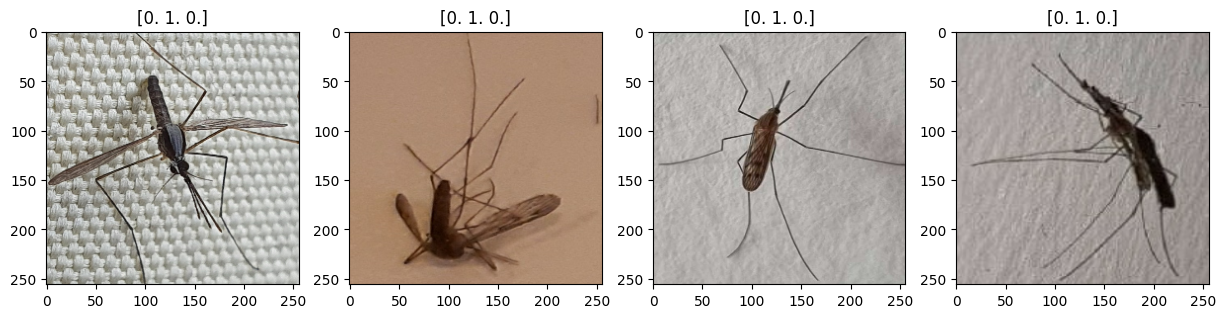

In [10]:
# Visualize data
fig, ax = plt.subplots(ncols=4, figsize=(15,15))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [11]:
len(data)

16

In [12]:
# Seperate batches
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) + 1

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

Build model

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

Train model

In [18]:
hist = model.fit(train, epochs=25, validation_data=val)

Epoch 1/25
11/11 [==============================] - 3s 180ms/step - loss: 1.6428 - accuracy: 0.3693 - val_loss: 1.0941 - val_accuracy: 0.5625
Epoch 2/25
11/11 [==============================] - 2s 178ms/step - loss: 1.0944 - accuracy: 0.3693 - val_loss: 1.0891 - val_accuracy: 0.5000
Epoch 3/25
11/11 [==============================] - 2s 180ms/step - loss: 1.0872 - accuracy: 0.4318 - val_loss: 1.0508 - val_accuracy: 0.4167
Epoch 4/25
11/11 [==============================] - 2s 181ms/step - loss: 1.0726 - accuracy: 0.5852 - val_loss: 1.0391 - val_accuracy: 0.5833
Epoch 5/25
11/11 [==============================] - 3s 226ms/step - loss: 1.0503 - accuracy: 0.4148 - val_loss: 1.0248 - val_accuracy: 0.5833
Epoch 6/25
11/11 [==============================] - 3s 224ms/step - loss: 1.0308 - accuracy: 0.5227 - val_loss: 1.0168 - val_accuracy: 0.4792
Epoch 7/25
11/11 [==============================] - 3s 241ms/step - loss: 0.9455 - accuracy: 0.5625 - val_loss: 0.8599 - val_accuracy: 0.7500
Epoch 

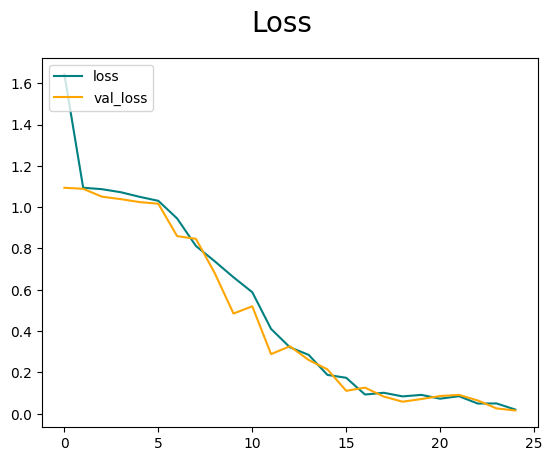

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

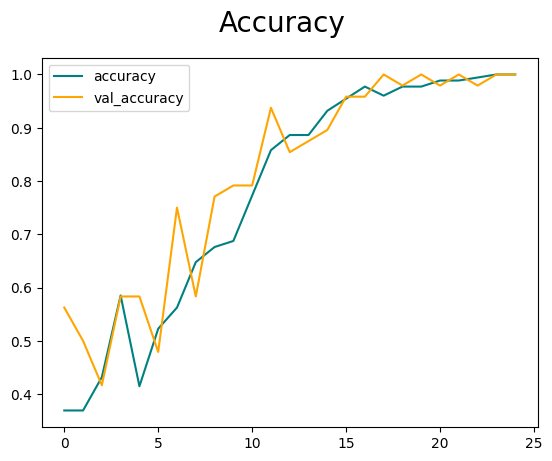

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
test_dir = os.path.join(root_dir, "vgu-dataset")
img = cv2.imread(os.path.join(test_dir, "0007.jpg"))
resize = tf.image.resize(img, (256,256))

In [22]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 105ms/step


In [23]:
for x in yhat:
    for i, y in enumerate(x):
        if y > 0.5:
            print(image_class[i], ": ", y)

Aedes Aegypti :  0.9999423


In [24]:
model.save(os.path.join(root_dir, "models", "mosquitoes_model.keras"))